In [105]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split, KFold, GridSearchCV, ParameterGrid, StratifiedKFold
from sklearn.metrics import mean_squared_error,r2_score,roc_curve,auc,precision_recall_curve
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.ensemble import GradientBoostingRegressor,GradientBoostingClassifier, BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier,AdaBoostRegressor,AdaBoostClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image
import pydotplus
import time as time
import itertools as it

import statsmodels.formula.api as sm
from collections import OrderedDict


In [204]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## Data Prep

In [236]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [238]:
train = train.rename(columns={"On-board service": "Onboard_service"})
test = test.rename(columns={"On-board service": "Onboard_service"})

In [240]:
#encode satisfaciton column values to 0 for dissatisfied and 1 for satisfied
train["satisfaction"] = train["satisfaction"].replace(['neutral or dissatisfied'], '0')
train["satisfaction"] = train["satisfaction"].replace(['satisfied'], '1')

test["satisfaction"] = test["satisfaction"].replace(['neutral or dissatisfied'], '0')
test["satisfaction"] = test["satisfaction"].replace(['satisfied'], '1')

#make dummy for categorical variables
train_dummies = pd.get_dummies(train[["Gender", "Customer Type", "Type of Travel", "Class"]])
train = pd.concat([train, train_dummies], axis=1)
train = train.drop(columns=["Gender", "Customer Type", "Type of Travel", "Class"])

test_dummies = pd.get_dummies(test[["Gender", "Customer Type", "Type of Travel", "Class"]])
test = pd.concat([test, test_dummies], axis=1)
test = test.drop(columns=["Gender", "Customer Type", "Type of Travel", "Class"])

#drop na
train = train.dropna()
test = test.dropna()

train = train.drop(columns=["Unnamed: 0", "id"])
test = test.drop(columns=["Unnamed: 0", "id"])

In [241]:
train.columns = train.columns.str.replace(' ', '_')
train.columns = train.columns.str.replace('/', '_')

test.columns = test.columns.str.replace(' ', '_')
test.columns = test.columns.str.replace('/', '_')

test.columns = test.columns.str.replace('-', '_')
test.columns = test.columns.str.replace('-', '_')

In [242]:
train["satisfaction"] = train["satisfaction"].astype(int)
test["satisfaction"] = test["satisfaction"].astype(int)

In [243]:
X = train.drop(columns=["satisfaction"])
y = train["satisfaction"]

Xtest = test.drop(columns=["satisfaction"])
ytest = test["satisfaction"]

## Linear Models (303-2 Models)

In [ ]:
#Function to compute confusion matrix and prediction accuracy on test/train data
def confusion_matrix_data(data,actual_values,model,cutoff=0.5):
    #Predict the values using the Logit model
    pred_values = model.predict_proba(data)[:,1]
    # Specify the bins
    bins=np.array([0,cutoff,1])
    #Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
    # Calculate the accuracy
    accuracy = 100*(cm[0,0]+cm[1,1])/cm.sum()
    fnr = 100*(cm[1,0])/(cm[1,0]+cm[1,1])
    precision = 100*(cm[1,1])/(cm[0,1]+cm[1,1])
    fpr = 100*(cm[0,1])/(cm[0,0]+cm[0,1])
    tpr = 100*(cm[1,1])/(cm[1,0]+cm[1,1])
    print("Accuracy = ", accuracy)
    print("Precision = ", precision)
    print("FNR = ", fnr)
    print("FPR = ", fpr)
    print("TPR or Recall = ", tpr)
    print("Confusion matrix = \n", cm_df)
    return (" ")

### Forward Selection

In [ ]:
#Function to compute confusion matrix and prediction accuracy on test data
def confusion_matrix(data, actual_values, model, cutoff = 0.5):
    #Predict the values using the Logit model
    pred_values = model.predict(data)
    # Specify the bins
    bins = np.array([0, cutoff, 1])
    # Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins = bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index = {0: 'Actual 0', 1: 'Actual 1'})
    # Calculate the accuracy
    accuracy = 100 * (cm[0, 0] + cm[1, 1]) / cm.sum()
    # Return the confusion matrix and the accuracy
    return cm_df, accuracy

In [ ]:
#Function to develop a model based on all predictors in predictor_subset
def processSubset(predictor_subset):
    # Fit model on feature_set and calculate R-squared
    model = sm.logit('satisfaction ~ ' + '+'.join(predictor_subset), data = train).fit(disp=0)
    Accuracy = confusion_matrix(train, train.satisfaction, model)[1]
    return {"model": model, "Accuracy": Accuracy}

In [ ]:
#Function to find the best predictor out of p-k predictors and add it to the model containing the k predictors
def forward(predictors):
    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    tic = time.time()
    results = []
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
        
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest Accuracy
    best_model = models.loc[models['Accuracy'].argmax()]
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1,"predictors in", (toc-tic), "seconds.")
    # Return the best model, along with some other useful information about the model
    return best_model

In [ ]:
def forward_selection():
    models_best = pd.DataFrame(columns = ["Accuracy", "model"])
    tic = time.time()
    predictors = []
    for i in range(1, len(X.columns)+1):
        models_best.loc[i] = forward(predictors)
        predictors = list(models_best.loc[i]["model"].params.index[1:])
        # Extra handling for qualitative variables
        for i in range(len(predictors)):
            predictors[i] = predictors[i].split('[')[0]
        # Removing duplicates
        predictors = list(OrderedDict.fromkeys(predictors))
    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

In [247]:
def best_sub_plots(models_best):
    plt.figure(figsize = (20,15))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})
    # Set up a 2x2 grid so we can look at 4 plots at once
    plt.subplot(3, 2, 1)
    # We will now plot a red dot to indicate the model with the largest training Accuracy statistic.
    plt.plot(models_best["Accuracy"])
    plt.plot(1 + models_best["Accuracy"].argmax(), models_best["Accuracy"].max(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('Training Accuracy')
    plt.text(1 + models_best["Accuracy"].argmax(), models_best["Accuracy"].max(), str(1 + models_best["Accuracy"].argmax()),
            verticalalignment='bottom', horizontalalignment='right')
    
    # We will now plot a red dot to indicate the model with the smallest training FNR statistic.
    models_best['FNR'] = models_best.apply(lambda row: fnr(confusion_matrix(train, train.satisfaction, row[1])), axis=1)
    plt.subplot(3, 2, 2)
    plt.plot(models_best['FNR'])
    plt.plot(1 + models_best['FNR'].argmin(), models_best['FNR'].min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('Training FNR')
    plt.text(1 + models_best['FNR'].argmin(), models_best['FNR'].min(), str(1 + models_best['FNR'].argmin()),
            verticalalignment='bottom', horizontalalignment='right')
    
    # We will now plot a red dot to indicate the model with the largest testing Accuracy statistic.
    models_best['TestingAccuracy'] = models_best.apply(lambda row: confusion_matrix(test, test.satisfaction, row[1])[1], axis=1)
    plt.subplot(3, 2, 3)
    plt.plot(models_best['TestingAccuracy'])
    plt.plot(1+models_best['TestingAccuracy'].argmax(), models_best['TestingAccuracy'].max(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('Testing Accuracy')
    plt.text(1+models_best['TestingAccuracy'].argmax(), models_best['TestingAccuracy'].max(), str(1+models_best['TestingAccuracy'].argmax()),
            verticalalignment='bottom', horizontalalignment='right')
    
    # We will now plot a red dot to indicate the model with the smallest testing FNR statistic.
    models_best['TestingFNR'] = models_best.apply(lambda row: fnr(confusion_matrix(test, test.satisfaction, row[1])), axis=1)
    plt.subplot(3, 2, 4)
    plt.plot(models_best['TestingFNR'])
    plt.plot(1 + models_best['TestingFNR'].argmin(), models_best['TestingFNR'].min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('Testing FNR')
    plt.text(1 + models_best['TestingFNR'].argmin(), models_best['TestingFNR'].min(), str(1 + models_best['TestingFNR'].argmin()),
            verticalalignment='bottom', horizontalalignment='right')
    
    # Minimum accuracy
    models_best['MinAccuracy'] = models_best[['Accuracy', 'TestingAccuracy']].min(axis = 1)
    plt.subplot(3, 2, 5)
    plt.plot(models_best["MinAccuracy"], color = "orange")
    plt.plot(1 + models_best["MinAccuracy"].argmax(), models_best["MinAccuracy"].max(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('Minimum Accuracy')
    plt.text(1 + models_best["MinAccuracy"].argmax(), models_best["MinAccuracy"].max(), str(1 + models_best["MinAccuracy"].argmax()),
            verticalalignment='bottom', horizontalalignment='right')
    
    # Maximum FNR
    models_best['MaxFNR'] = models_best[['FNR', 'TestingFNR']].max(axis = 1)
    plt.subplot(3, 2, 6)
    plt.plot(models_best['MaxFNR'], color = "orange")
    plt.plot(1 + models_best['MaxFNR'].argmin(), models_best['MaxFNR'].min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('Maximum FNR')
    plt.text(1 + models_best['MaxFNR'].argmin(), models_best['MaxFNR'].min(), str(1 + models_best['MaxFNR'].argmin()),
            verticalalignment='bottom', horizontalalignment='right')
    

In [205]:
models_best = forward_selection()

Processed  27 models on 1 predictors in 1.174184799194336 seconds.
Processed  26 models on 2 predictors in 1.4187240600585938 seconds.
Processed  25 models on 3 predictors in 1.7550790309906006 seconds.
Processed  24 models on 4 predictors in 1.9309959411621094 seconds.
Processed  23 models on 5 predictors in 4.01934289932251 seconds.
Processed  22 models on 6 predictors in 4.507567882537842 seconds.
Processed  21 models on 7 predictors in 4.746961832046509 seconds.
Processed  20 models on 8 predictors in 4.576616048812866 seconds.
Processed  19 models on 9 predictors in 3.8457159996032715 seconds.
Processed  18 models on 10 predictors in 4.763843059539795 seconds.
Processed  17 models on 11 predictors in 4.694478750228882 seconds.
Processed  16 models on 12 predictors in 4.697351932525635 seconds.
Processed  15 models on 13 predictors in 3.511518955230713 seconds.
Processed  14 models on 14 predictors in 3.75240421295166 seconds.
Processed  13 models on 15 predictors in 4.118559122085

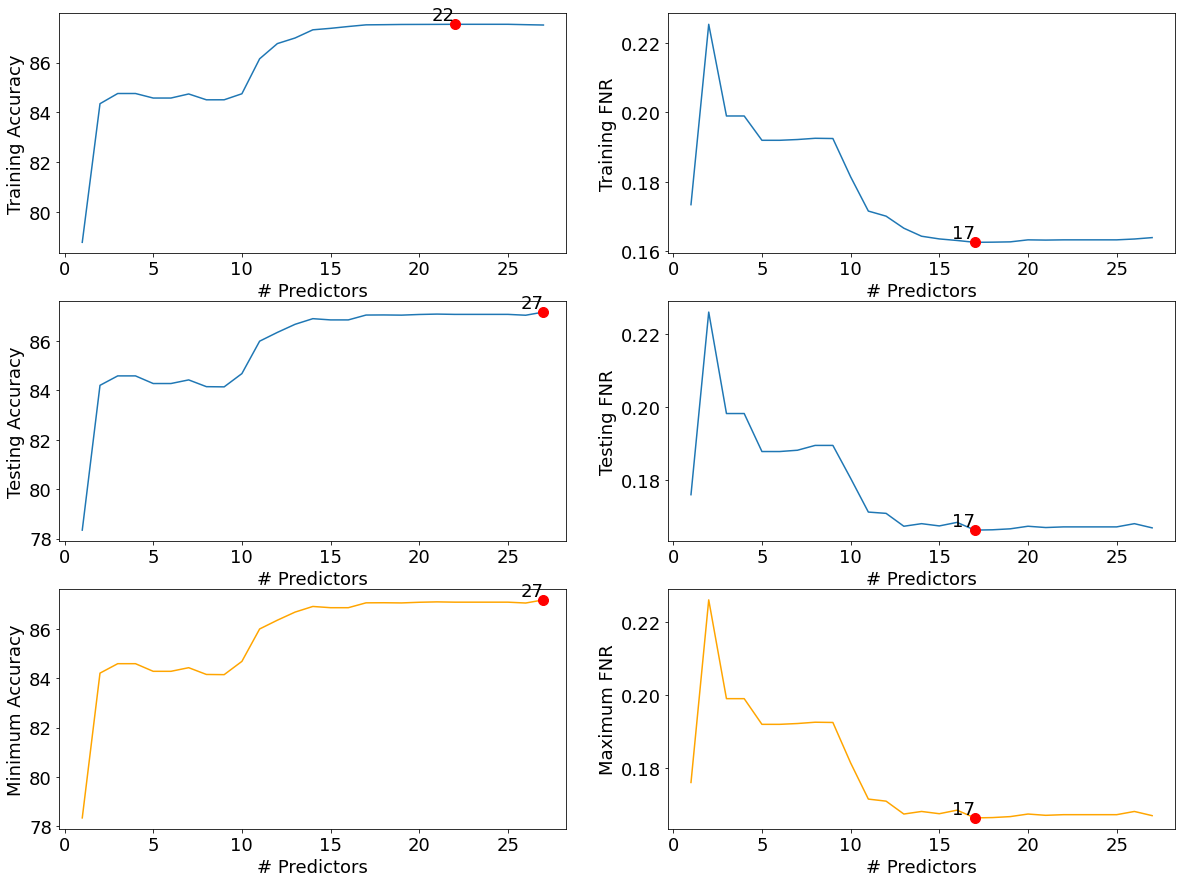

In [248]:
def fnr(matrix):
    return matrix[0].loc['Actual 1', 'Predicted 0'] / (matrix[0].loc['Actual 1', 'Predicted 0'] + matrix[0].loc['Actual 1', 'Predicted 1'])

best_sub_plots(models_best)

In [249]:
# Determined by best minimum classification accuracy
best_fwd_reg_model = models_best['model'][17]
best_fwd_reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           satisfaction   No. Observations:               103594
Model:                          Logit   Df Residuals:                   103577
Method:                           MLE   Df Model:                           16
Date:                Sat, 14 May 2022   Pseudo R-squ.:                  0.5096
Time:                        14:05:01   Log-Likelihood:                -34758.
converged:                       True   LL-Null:                       -70884.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -6.7943   1.23e+06  -5.52e-06      1.000   -2.41e+06    2.41e+06
Online_boarding                       0.5939      0.010     60.955      0.000       0.575       0.613
Type_of_Travel_Business_travel       -2.0521   1.23e+06  -1.67e-06      1.000   -2.41e+06    2.41e+06
Inflight_wifi_service                 0.3201      0.010     33.575      0.000       0.301       0.339
Type_of_Travel_Personal_Travel       -4.7423   1.23e+06  -3.86e-06      1.000   -2.41e+06    2.41e+06
Inflight_entertainment                0.0756      0.012      6.071      0.000       0.051       0.100
Cleanliness                           0.2543      0.011     22.839      0.000       0.232       0.276
Class_Eco_Plus                       -0.1044      0.040     -2.639      0.008      -0.182      -0.027
Gate_location                        -0.0056      0.009     -0.643      0.520      -0.023       0.011
Departure_Arrival_time_convenient    -0.1569      0.008    -19.941      0.000      -0.172      -0.142
Customer_Type_Loyal_Customer          1.9807      0.028     71.568      0.000       1.926       2.035
Onboard_service                       0.2943      0.010     29.344      0.000       0.275       0.314
Checkin_service                       0.3284      0.008     38.792      0.000       0.312       0.345
Class_Business                        0.7175      0.024     29.722      0.000       0.670       0.765
Leg_room_service                      0.2455      0.008     29.022      0.000       0.229       0.262
Inflight_service                      0.1255      0.012     10.604      0.000       0.102       0.149
Baggage_handling                      0.1425      0.011     12.622      0.000       0.120       0.165
Arrival_Delay_in_Minutes             -0.0048      0.000    -18.287      0.000      -0.005      -0.004
=====================================================================================================
"""

In [47]:
cf_test = confusion_matrix(Xtest, ytest, best_fwd_reg_model, 0.9)
cm = cf_test[0]
precision = cm['Predicted 1']['Actual 1'] / (cm['Predicted 1']['Actual 0'] + cm['Predicted 1']['Actual 1'])

print(cf_test)
print("Precision:", precision)

(          Predicted 0  Predicted 1
Actual 0      14468.0         60.0
Actual 1       5618.0       5747.0, 78.07129339976055)
Precision: 0.9896676425004305


### Accuracy on Test: 78.07%
### Precision on Test: 98.97%

### Logistic Regression 

In [69]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

In [56]:
parameters = {
    "penalty": ['l1', 'l2', 'elasticnet'],
    "C": np.geomspace(0.01, 100, 5),
    "solver": ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

cv = KFold(n_splits = 5, shuffle = True, random_state = 1)
model = GridSearchCV(
    LogisticRegression(random_state = 1),
    parameters,
    n_jobs = -1,
    verbose = 1,
    cv = cv
)

model.fit(X, y)

Fitting 5 folds for each of 75 candidates, totalling 375 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=LogisticRegression(random_state=1), n_jobs=-1,
             param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             verbose=1)

In [57]:
model.best_params_

{'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}

In [75]:
model_updated = LogisticRegression(
    C = 0.01, penalty = 'l2', solver = 'newton-cg'
).fit(X, y)

print(confusion_matrix_data(Xtest,ytest,model_updated,cutoff=0.7))

Accuracy =  86.27042057698992
Precision =  93.85669362084457
FNR =  26.467223933128025
FPR =  3.765143171806167
TPR or Recall =  73.53277606687197
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0      13981.0        547.0
Actual 1       3008.0       8357.0
 


### Accuracy on Test: 86.27%
### Precision on Test: 93.86%

## Non-Linear Models (303-3 Models)

### Basic Decision Tree

In [110]:
parameters = {
    'max_depth': [10, 25, 50],
    'max_leaf_nodes': [50, 100, 200]
}

cv = KFold(n_splits = 5, shuffle = True, random_state = 1)
model = GridSearchCV(
    DecisionTreeClassifier(random_state = 1),
    parameters,
    n_jobs = -1,
    verbose = 1,
    cv = cv
)

model.fit(X, y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [10, 25, 50],
                         'max_leaf_nodes': [50, 100, 200]},
             verbose=1)

In [111]:
model.best_params_

{'max_depth': 25, 'max_leaf_nodes': 200}

In [112]:
model_updated = DecisionTreeClassifier(
    max_depth = 25, max_leaf_nodes = 200, random_state = 1
).fit(X, y)

cf_test = confusion_matrix(Xtest, ytest, model_updated, 0.9)
cm = cf_test[0]
accuracy = (cm['Predicted 0']['Actual 0'] + cm['Predicted 1']['Actual 1']) / (cm['Predicted 0'].sum() + cm['Predicted 1'].sum())
precision = cm['Predicted 1']['Actual 1'] / (cm['Predicted 1']['Actual 0'] + cm['Predicted 1']['Actual 1'])

print(cf_test)
print("Accuracy:", accuracy)
print("Precision:", precision)

(          Predicted 0  Predicted 1
Actual 0      14141.0        387.0
Actual 1        753.0      10612.0, 95.59726567025837)
Accuracy: 0.9559726567025837
Precision: 0.9648149831802891


### Accuracy on Test: 95.60%
### Precision on Test: 96.48%

### Bagged Decision Tree Model

Currently trying 10 estimators
Currently trying 65 estimators
Currently trying 121 estimators
Currently trying 177 estimators
Currently trying 232 estimators
Currently trying 288 estimators
Currently trying 344 estimators
Currently trying 400 estimators


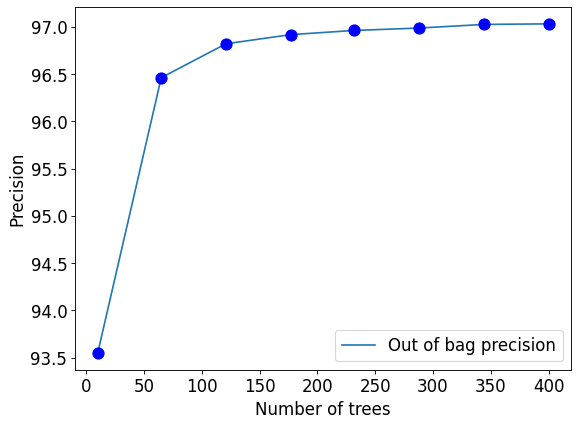

In [98]:
oob_precision = {}

for i in np.linspace(10, 400, 8, dtype = int):
    print(f"Currently trying {i} estimators")
    model = BaggingClassifier(
        base_estimator = DecisionTreeClassifier(),
        n_estimators = i, random_state = 1,
        n_jobs = -1, oob_score = True
    ).fit(X, y)
    
    oob_pred = model.oob_decision_function_[:,1]
    bins = np.array([0,0.5,1])
    cm = np.histogram2d(y, oob_pred, bins=bins)[0]
    oob_precision[i] = 100*(cm[1,1])/(cm[0,1]+cm[1,1])
    
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(oob_precision.keys(),oob_precision.values(),label = 'Out of bag precision')
plt.plot(oob_precision.keys(),oob_precision.values(),'o',color = 'blue')
plt.xlabel('Number of trees')
plt.ylabel('Precision')
plt.legend()

In [102]:
params = {
    'n_estimators': range(200, 425, 25)
}
param_list = list(it.product(*(params[name] for name in params)))
precision = [None for i in range(len(param_list))]

for index, pr in enumerate(param_list):
    print(f"Currently trying {pr[0]} estimators")
    model = BaggingClassifier(
        base_estimator = DecisionTreeClassifier(),
        n_estimators = pr[0], random_state = 1,
        n_jobs = -1, oob_score = True
    ).fit(X, y)
    
    oob_pred = model.oob_decision_function_[:,1]
    bins = np.array([0,0.5,1])
    cm = np.histogram2d(y, oob_pred, bins=bins)[0]
    precision[index] = 100*(cm[1,1])/(cm[0,1]+cm[1,1])

print("-----------------------")
print("max precision = ", np.max(precision))
print("params= ", param_list[np.argmax(precision)])

Currently trying 200 estimators
Currently trying 225 estimators
Currently trying 250 estimators
Currently trying 275 estimators
Currently trying 300 estimators
Currently trying 325 estimators
Currently trying 350 estimators
Currently trying 375 estimators
Currently trying 400 estimators
-----------------------
max precision =  97.0374280010097
params=  (350,)


In [107]:
model_updated = BaggingClassifier(
    base_estimator = DecisionTreeClassifier(),
    n_estimators = 350, random_state = 1,
    n_jobs = -1, oob_score = True
).fit(X, y)

In [108]:
print(confusion_matrix_data(Xtest,ytest,model_updated,cutoff=0.9))

Accuracy =  94.624029660526
Precision =  99.67128200019923
FNR =  11.957765068191817
FPR =  0.22714757709251102
TPR or Recall =  88.04223493180818
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0      14495.0         33.0
Actual 1       1359.0      10006.0
 


### Accuracy on Test: 94.62%
### Precision on Test: 99.67%

### Random Forest

In [75]:
#Finding model accuracy vs number of trees
oob_accuracy={};test_accuracy={};oob_precision={}; test_precision = {}

for i in np.linspace(50,500,45,dtype=int):
    model = RandomForestClassifier(n_estimators=i,
                                   random_state=1,max_features="sqrt",n_jobs=-1,oob_score=True).fit(X, y)
    oob_accuracy[i]=model.oob_score_ #Returns the out-of_bag R-squared of the model
    test_accuracy[i]=model.score(Xtest,ytest) #Returns the test R-squared of the model
    oob_pred = model.oob_decision_function_[:,1]
    bins=np.array([0,0.5,1])
    cm = np.histogram2d(y, oob_pred, bins=bins)[0]
    oob_precision[i] = 100*(cm[1,1])/(cm[0,1]+cm[1,1])
    test_pred = model.predict_proba(Xtest)[:,1]
    cm = np.histogram2d(ytest, test_pred, bins=bins)[0]
    test_precision[i] = 100*(cm[1,1])/(cm[0,1]+cm[1,1])

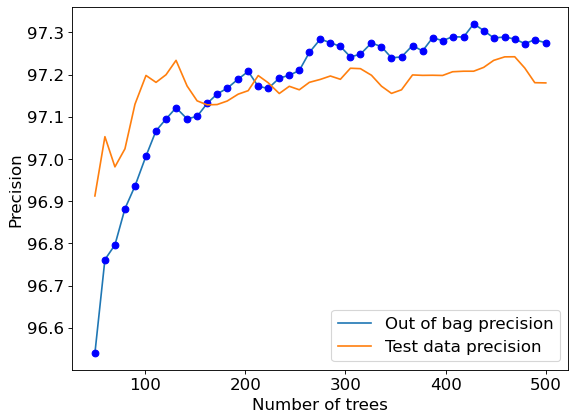

In [76]:
#Precision vs number of trees
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(oob_precision.keys(),oob_precision.values(),label = 'Out of bag precision')
plt.plot(oob_precision.keys(),oob_precision.values(),'o',color = 'blue')
plt.plot(test_precision.keys(),test_precision.values(), label = 'Test data precision')
plt.xlabel('Number of trees')
plt.ylabel('Precision')
plt.legend()

In [89]:
params = {'n_estimators': [400, 450, 500],
          'max_features': range(2,28)
         }

param_list=list(it.product(*(params[Name] for Name in list(params.keys()))))
precision = [0]*len(param_list)

len(precision)

78

In [90]:
i=0

for pr in param_list:
    print(i)
    model = RandomForestClassifier(random_state=1,
                                   oob_score=True,
                                   verbose=False,
                                   n_estimators= pr[0],
                                   max_features=pr[1], n_jobs=-1).fit(X,y)
    oob_pred = model.oob_decision_function_[:,1]
    bins=np.array([0,0.5,1])
    cm = np.histogram2d(y, oob_pred, bins=bins)[0]
    precision[i] = 100*(cm[1,1])/(cm[0,1]+cm[1,1])
    i=i+1

print("max precision = ", np.max(precision))
print("params= ", param_list[np.argmax(precision)])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
max recall =  97.47164515609543
params=  (450, 13)


In [91]:
model = RandomForestClassifier(random_state=1,n_jobs=-1,max_features=13,n_estimators=450).fit(X, y)

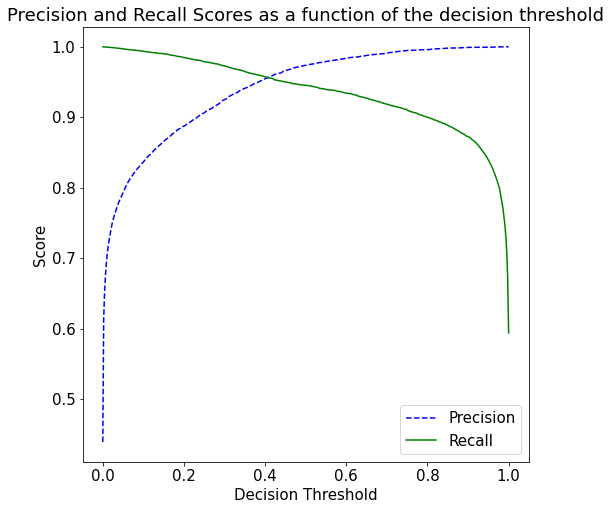

In [96]:
ypred = model.predict_proba(Xtest)[:, 1]
p, r, thresholds = precision_recall_curve(ytest, ypred)
plot_precision_recall_vs_threshold(p, r, thresholds)

In [97]:
print(confusion_matrix_data(X,y,model,cutoff=0.9))
print(confusion_matrix_data(Xtest,ytest,model,cutoff=0.9))

Accuracy =  96.20634399675657
Precision =  100.0
FNR =  8.753368821970287
FPR =  0.0
TPR or Recall =  91.24663117802972
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0      58697.0          0.0
Actual 1       3930.0      40967.0
 
Accuracy =  94.35754837214691
Precision =  99.89923417976622
FNR =  12.767267927848659
FPR =  0.06883259911894272
TPR or Recall =  87.23273207215134
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0      14518.0         10.0
Actual 1       1451.0       9914.0
 


### Accuracy on Test: 94.36%
### Precision on Test: 99.89%

## Summary of (Base) Model Performances:

NOTE: **Bold** indicates the best 2 models for a given metric.

* Forward Selection [0.9 cutoff]: 
  * Accuracy (on Test): 78.07%
  * Precision (on Test): 98.97% 
* Logistic Regression [0.7 cutoff]:
  * Accuracy: 86.27%
  * Precision: 93.86%
* Basic Decision Tree [0.9 cutoff]:
  * **Accuracy: 95.60%**
  * Precision: 96.48%
* Bagged Decision Tree [0.9 cutoff]:
  * **Accuracy: 94.62%**
  * **Precision: 99.67%**
* Random Forest [0.9 cutoff]:
  * Accuracy: 94.36%
  * **Precision: 99.89%**